*Groupe* : MANDINE Loïc, MALTESE Salomé, RAIGE-VERGER Julien, DENIS Hansi. 

**Référent :** Thomas Mahiout


*Hill Valley Dataset* : [Dataset OpenML](https://www.openml.org/d/1479)

[Pour télécharger les données](http://archive.ics.uci.edu/ml/machine-learning-databases/hill-valley/)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports tools

In [ ]:
pip install captum

In [ ]:
from typing import List, Tuple, Dict

import random

from itertools import product

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


!pip install -qqqq colorama
from colorama import Fore, Back, Style

from pprint import pprint
from captum.attr import GuidedGradCam,GuidedBackprop

In [ ]:
!ls 

drive  sample_data


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Data Loading 

for data in ["Hill_Valley_with_noise_Testing.data", 
             "Hill_Valley_with_noise_Training.data", 
             "Hill_Valley_without_noise_Testing.data", 
             "Hill_Valley_without_noise_Training.data"]:
    ! wget -qq http://archive.ics.uci.edu/ml/machine-learning-databases/hill-valley/$data

In [ ]:
def construct_path(noisy : bool = True, 
                   train_set : bool = True) -> str :
    """
    Construct the path according to some parameters. 

    Args:
        noisy (boolean) - Indicates if we load the noisy (if True) or smooth (if False) data's version
        train_set (boolean) - Indicates if we load the training (if True) or testing (if False) dataset

    Return:
        string - path of one data file 
    """

    path = "/content/drive/MyDrive/Mam5/ATDL/mini_project/"

    path += "noisy_data/Hill_Valley_with_noise_" if noisy else "smooth_data/Hill_Valley_without_noise_"

    path += "Training.data" if train_set else "Testing.data"

    return path

def load_data(noisy : bool = True, 
              train_set : bool = True) -> Tuple[np.ndarray,np.ndarray]: 
    """
    Load the dataset into two numpy array: Data (1D discrete signal) and Labels

    Args:
        noisy (boolean) - Indicates if we load the noisy (if True) or smooth (if False) data's version
        train_set (boolean) - Indicates if we load the training (if True) or testing (if False) dataset

    Return:
        (np.ndarray[..., 101], np.ndarray[..., 1]) - two numpy array: Data (1D discrete signal) and Labels
    """

    dataset_path = construct_path(noisy, train_set)

    with open(dataset_path) as f :
        # we split two times according to different characters
        # in order to have a resulting list with one item corresponding to one number on the file
        data = f.read().split("\n")[1:]
        data = ",".join(data).split(",")[:-1]
        
    # given the list mentionned above, we return the corresponding numpy array
    res = np.array([float(number) for number in data]).reshape((-1,101))
    return res[:, :100], res[:, -1]

def gen_all_dataset_in_var() -> Dict[str, List[Dict[str, Tuple[np.ndarray,np.ndarray]]]]:
    """
    Function for further convenience, we regroup all the the four datasets possible in a dict
    """
    res = {}
    for bool_noise in [True,False]:
        first_key = "noise" if bool_noise else "smooth"
        res[first_key]={ "train" : load_data(bool_noise, True),
                         "test" : load_data(bool_noise, False)}

    return res

datasets = gen_all_dataset_in_var()
pprint(datasets)

{'noise': {'test': (array([[   29.62,    27.95,    27.52, ...,    27.11,    28.63,    28.42],
       [   59.69,    54.68,    50.37, ...,    53.09,    59.26,    58.83],
       [   54.59,    52.12,    54.98, ...,    49.24,    49.59,    55.71],
       ...,
       [10160.65,  9048.63,  8994.94, ..., 10366.24,  8997.6 ,  9305.77],
       [   34.81,    35.07,    34.98, ...,    32.49,    32.83,    34.82],
       [ 8489.43,  7672.98,  9132.14, ...,  8679.43,  8389.31,  8712.8 ]]),
                    array([1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0

# Datasets Vizualisation and Distribution

In [ ]:
noisy_dataset, smooth_dataset = datasets["noise"], datasets["smooth"]

print("Noisy samples")
print("\t We have",noisy_dataset["train"][0].shape[0],"samples in our Training set")
print(f"\t We have",noisy_dataset["test"][0].shape[0], "samples in our Testing set")

print("Smooth samples")
print(f"\t We have",smooth_dataset["train"][0].shape[0], "samples in our Training set")
print(f"\t We have",smooth_dataset["test"][0].shape[0], "samples in our Testing set")

Noisy samples
	 We have 606 samples in our Training set
	 We have 606 samples in our Testing set
Smooth samples
	 We have 606 samples in our Training set
	 We have 606 samples in our Testing set


**Label encoding**:

*   0 -> Valley
*   1 -> Hill



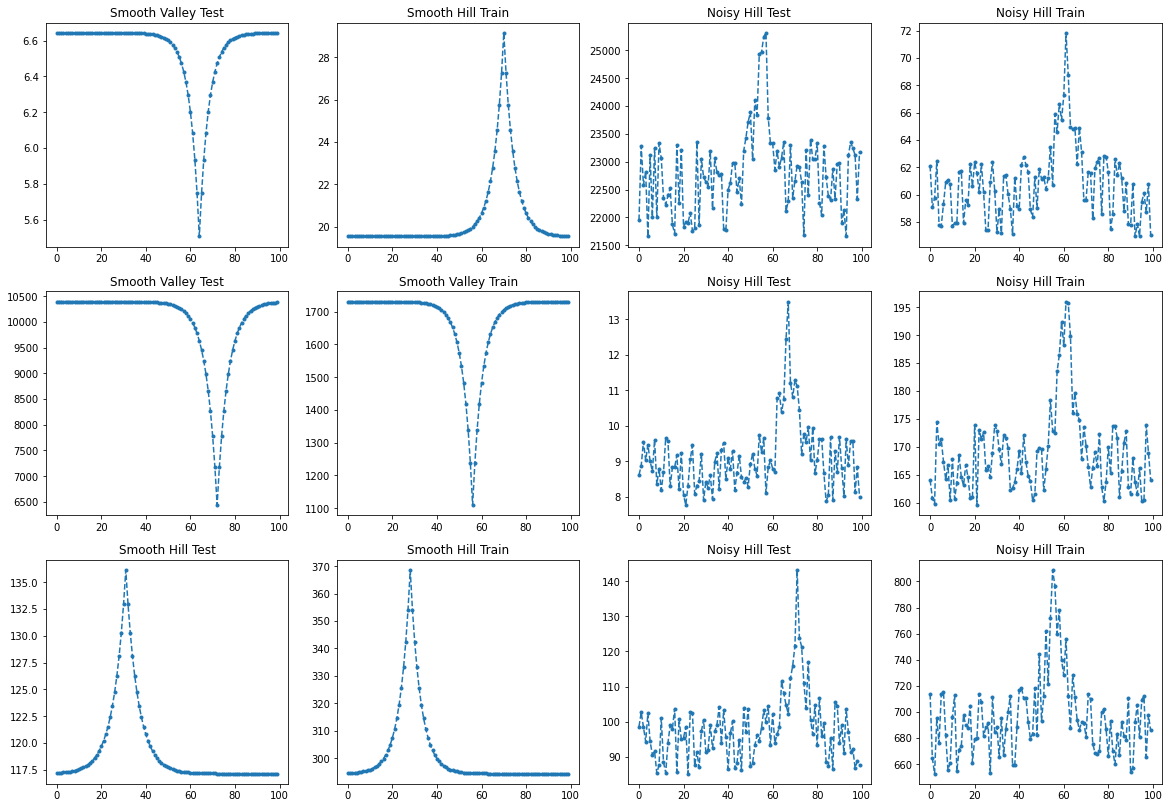

In [ ]:
nb_of_exp = 3
fig, axs = plt.subplots(nb_of_exp, 4, figsize = (20, 14))

idx_samples = np.random.randint(0,noisy_dataset["train"][0].shape[0],4)
for i in range(nb_of_exp*4):

    col = i % 4
    row = i // 4

    rand_sample = datasets["noise" if col//2 else "smooth"]["train" if col%2 else "test"]
    data_plotted, label = rand_sample[0][idx_samples[row],:], rand_sample[1][idx_samples[row]]

    axs[row, col].plot( data_plotted, '--.' )
    axs[row, col].set_title(("Noisy " if col//2 else "Smooth ")+("Hill " if label else "Valley ")+("Train" if col%2 else "Test"))

# Implementation of a Binary Classification Solution

## Deep Learning

### Custom Dataset

In [ ]:
class dataset(Dataset):
  """
  A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. 
  The __init__ function is run once when instantiating the Dataset object. 
  The __len__ function returns the number of samples in our dataset.
  The __getitem__ function loads and returns a sample from the dataset at the given index idx. 
  """
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

In [ ]:
x_smooth = np.concatenate((smooth_dataset['train'][0], smooth_dataset['test'][0]))
y_smooth = np.concatenate((smooth_dataset['train'][1], smooth_dataset['test'][1]))

In [ ]:
x_noise = np.concatenate((noisy_dataset['train'][0], noisy_dataset['test'][0]))
y_noise = np.concatenate((noisy_dataset['train'][1], noisy_dataset['test'][1]))

### Splitting Train-Validation-Test

In [ ]:
x_train_smooth, x_test_smooth, y_train_smooth, y_test_smooth = train_test_split(x_smooth, y_smooth, test_size=0.2, random_state=42)
x_train_smooth, x_valid_smooth, y_train_smooth, y_valid_smooth = train_test_split(x_train_smooth, y_train_smooth, test_size=0.25, random_state=42)

x_train_noise, x_test_noise, y_train_noise, y_test_noise = train_test_split(x_noise, y_noise, test_size=0.2, random_state=42)
x_train_noise, x_valid_noise, y_train_noise, y_valid_noise = train_test_split(x_train_noise, y_train_noise, test_size=0.25, random_state=42)

#Same number of samples for smooth and noisy dataset
print("Number of training samples: ",len(x_train_noise))
print("Number of validation samples: ",len(x_valid_noise))
print("Number of testing samples: ",len(x_test_noise))

Number of training samples:  726
Number of validation samples:  243
Number of testing samples:  243


### Data Normalization

We do a data normalization by rows : we normalize each utterance of 100 points to have normal distribution with mean = 0 and variance = 1. It is needed for neural network to learn correctly as utterance scale can vary a lot (as we can see in the dataset vizualisation). 

In [ ]:
# use of standard scaler from sklearn library to normalize data
def rescale(x):
  scaler = StandardScaler()
  #scaler = MinMaxScaler(feature_range=(-1,1))
  res = x.copy()
  for i in range(x.shape[0]):
    res[i] = scaler.fit_transform(x[i].reshape(-1, 1)).flatten()
  return res

In [ ]:
train_rescaled_smooth = rescale(x_train_smooth)
valid_rescaled_smooth = rescale(x_valid_smooth)

train_rescaled_noise = rescale(x_train_noise)
valid_rescaled_noise = rescale(x_valid_noise)

In [ ]:
# normalization of smooth and noisy test data
test_rescaled_smooth = rescale(x_test_smooth)
test_set_smooth = dataset(test_rescaled_smooth, y_test_smooth)

test_rescaled_noise = rescale(x_test_noise)
test_set_noise = dataset(test_rescaled_noise, y_test_noise)

### Dataloaders

In [ ]:
#smooth
train_set_smooth = dataset(train_rescaled_smooth,y_train_smooth)
valid_set_smooth = dataset(valid_rescaled_smooth,y_valid_smooth)

train_dl_smooth = DataLoader(train_set_smooth,batch_size=64)
valid_dl_smooth = DataLoader(valid_set_smooth,batch_size=64)

#noisy
train_set_noise = dataset(train_rescaled_noise,y_train_noise)
valid_set_noise = dataset(valid_rescaled_noise,y_valid_noise)

train_dl_noise = DataLoader(train_set_noise,batch_size=64)
valid_dl_noise = DataLoader(valid_set_noise,batch_size=64)

### Functions for train and test loop

In [ ]:
def training(train_dl, valid_dl, model, device, epochs, n_train, n_valid,conv=False):
  # defining the optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0)

  # defining the loss function
  criterion = nn.BCELoss()

  model = model.to(device)
  criterion = criterion.to(device)

  # to save kernel weights at each epoch
  kernel_weights = []

  # to compute guided GradCam through epochs
  guided_gc = []

  #forward loop
  epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []
  for e in range(epochs):

    running_loss = 0
    running_accuracy = 0
    ## Put the network in training mode
    model.train()

    for x,targets in train_dl:
      
      # move the batch to GPU
      x = x.to(device)
      targets = targets.to(device)

      # Compute the network output
      if conv:
        output = model(x.unsqueeze(2).transpose(1, 2))
        output = output.squeeze(2).squeeze(1)
      else:
        output = model(x)
        output = output.squeeze(1)
      
      # compute the loss
      loss = criterion(output,targets)

      # Reset the gradients
      optimizer.zero_grad()

      # Compute the gradients
      loss.backward()

      # Apply one step of the descent algorithm to update the weights
      optimizer.step()

      ## Compute some statistics
      with torch.no_grad():
        running_loss += loss.item()
        running_accuracy += torch.eq(torch.round(output), targets).sum().item()

    epoch_loss.append(running_loss/n_train)
    epoch_acc.append(running_accuracy/n_train)
    if conv:
      kernel_weights.append(model.conv1.weight.cpu().detach().clone())

    if e%10 == 0:
      print("Training {}\tloss : {}\t accuracy : {}".format(e,epoch_loss[e],epoch_acc[e]))
      #guided_gc.append(GuidedGradCam(model, model.conv1))
      if e==0:
        plt.plot(x[1].cpu().detach().numpy())
        plt.show()
      output = x[1].unsqueeze(1).transpose(0,1)
      output = output.unsqueeze(2).transpose(2,1)
      output = output.to(device)
      output = output.float()
      #We compute the Guided GradCam activations for a given sample and plot them
      output.requires_grad=True
      if conv:
        explainer = GuidedGradCam(model, model.conv1)
      else:
        explainer = GuidedBackprop(model)
      attribution = explainer.attribute(output, 0)
      plt.plot(attribution[0][0].cpu().detach().numpy())
      #savefig used for the presentation
      #name = 'epoch_' + str(e)
      #plt.savefig("/content/drive/MyDrive/Mam5/ATDL/" + name)
      plt.show()

    ### VALIDATION LOOP
    ## Put the network in validation mode
    model.eval()
    
    running_val_loss = 0
    running_val_accuracy = 0
    
    for x,targets in valid_dl:
      
      with torch.no_grad():

        # move the batch to GPU
        x = x.to(device)
        targets = targets.to(device)

        # Compute the network output
        if conv:
          output = model(x.unsqueeze(2).transpose(1, 2))
          output = output.squeeze(2).squeeze(1)
        else: 
          output = model(x)
          output = output.squeeze(1)
        
        # Compute the loss
        loss = criterion(output, targets)
        
        running_val_loss += loss.item()
        running_val_accuracy += torch.eq(torch.round(output), targets).sum().item()

    epoch_val_loss.append(running_val_loss/n_valid)
    epoch_val_acc.append(running_val_accuracy/n_valid)

    if e%10 == 0:
      print("Validation {}\tloss : {}\t accuracy : {}".format(e,epoch_val_loss[e],epoch_val_acc[e]))
  return model, criterion, kernel_weights, guided_gc

In [ ]:
def test(test_set, model, criterion, device, conv=False):
  
  model.eval()

  test_loss = 0
  test_accuracy = 0

  with torch.no_grad():

    x = test_set.x
    targets = test_set.y
    # move the batch to GPU
    x = x.to(device)
    targets = targets.to(device)

    # Compute the network output
    if conv:
      output = model(x.unsqueeze(2).transpose(1, 2))
      output = output.squeeze(2).squeeze(1)
    else:
      output = model(x).squeeze(1)

    # Compute the loss
    loss = criterion(output, targets)

    test_loss += loss.item()
    test_accuracy += torch.eq(torch.round(output), targets).sum().item()

  print("Test loss : {}\t accuracy : {}".format(test_loss/len(test_set), test_accuracy/len(test_set)))

### Conv1D trainable NN


In [ ]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        ## First convolution
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=7)

        ## Activation layer
        self.relu = nn.ReLU()

        # Output layer
        self.output = nn.Linear(94,1)

        # Global max pooling layer
        self.pool = nn.MaxPool1d(kernel_size = 94)
        
        ## Final activation layer
        self.softmax = nn.Softmax(dim=1)

    # Defining the forward pass    
    def forward(self, x):
        ## First convolution + activation
        x = self.conv1(x)
        x = x.to(device)
        x = self.relu(x)
        ## Output layer
        x = self.output(x)
        #x = self.pool(x)
        y = torch.sigmoid(x)
        return y

In [ ]:
# to use google Colab GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Guided GradCAM

#### Smooth data

Training 0	loss : 0.010634223209596535	 accuracy : 0.650137741046832


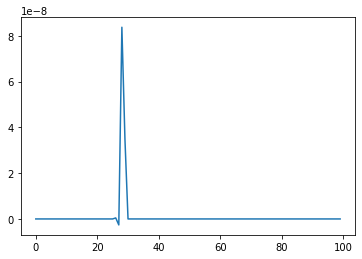

Validation 0	loss : 0.010288765155729443	 accuracy : 0.7695473251028807
Training 10	loss : 0.0064863956664219374	 accuracy : 0.918732782369146


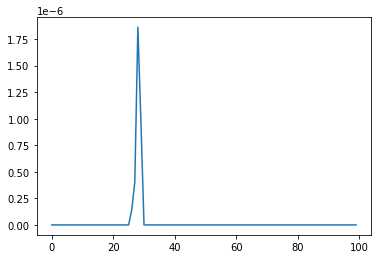

Validation 10	loss : 0.00638994390581861	 accuracy : 0.9218106995884774
Training 20	loss : 0.004198803984593426	 accuracy : 0.9462809917355371


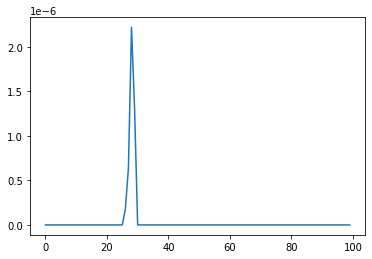

Validation 20	loss : 0.004213624898298287	 accuracy : 0.9259259259259259
Training 30	loss : 0.0029446420775464744	 accuracy : 0.953168044077135


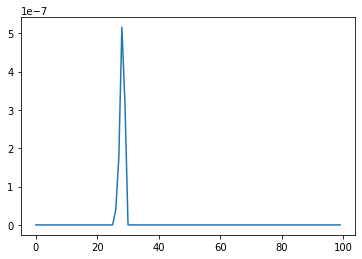

Validation 30	loss : 0.0029722566835183664	 accuracy : 0.9465020576131687
Training 40	loss : 0.0022121765663636944	 accuracy : 0.9614325068870524


Validation 40	loss : 0.0022309877499631404	 accuracy : 0.9588477366255144
Training 50	loss : 0.0017494530963503626	 accuracy : 0.9655647382920111


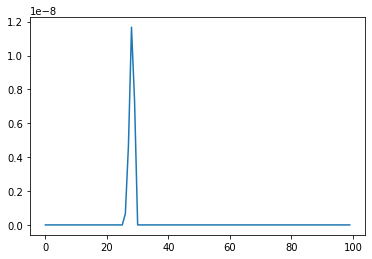

Validation 50	loss : 0.0017645049058360818	 accuracy : 0.9629629629629629
Training 60	loss : 0.0014418537931172972	 accuracy : 0.9765840220385675


Validation 60	loss : 0.0014552270740638544	 accuracy : 0.9711934156378601


In [ ]:
# defining the model
model = Net()

# smooth training
model_smooth_conv, criterion, kernel_weights, guided_gc = training(train_dl_smooth, 
                                   valid_dl_smooth, model, device, 70, len(x_train_smooth), 
                                   len(x_valid_smooth), conv=True)

#### Noisy data

Training 0	loss : 0.011642639219925095	 accuracy : 0.5041322314049587


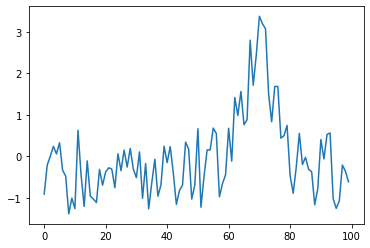

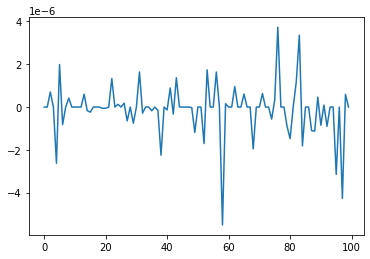

Validation 0	loss : 0.011543792952235343	 accuracy : 0.5185185185185185
Training 10	loss : 0.01140119664925189	 accuracy : 0.5192837465564738


Validation 10	loss : 0.011374230002179558	 accuracy : 0.5473251028806584
Training 20	loss : 0.01110801642591303	 accuracy : 0.5757575757575758


Validation 20	loss : 0.011143605404920539	 accuracy : 0.6172839506172839
Training 30	loss : 0.010248019511377843	 accuracy : 0.6859504132231405


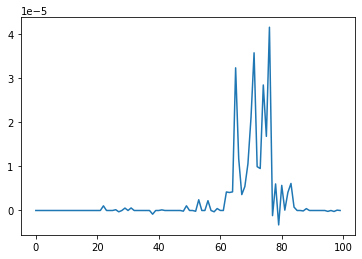

Validation 30	loss : 0.01020927684297287	 accuracy : 0.7530864197530864
Training 40	loss : 0.008444692477707036	 accuracy : 0.8443526170798898


Validation 40	loss : 0.008186538033034086	 accuracy : 0.8888888888888888
Training 50	loss : 0.006561732119765164	 accuracy : 0.8980716253443526


Validation 50	loss : 0.006208095162984275	 accuracy : 0.9135802469135802
Training 60	loss : 0.005280348798131811	 accuracy : 0.9214876033057852


Validation 60	loss : 0.004933441433396359	 accuracy : 0.9259259259259259


In [ ]:
# defining the model
model = Net()

# noisy training
model_noise_conv, criterion, kernel_weights, guided_gc = training(train_dl_noise, 
                                   valid_dl_noise, model, device, 70, len(x_train_noise), 
                                   len(x_valid_noise), conv=True)

### Visualization of filters learned

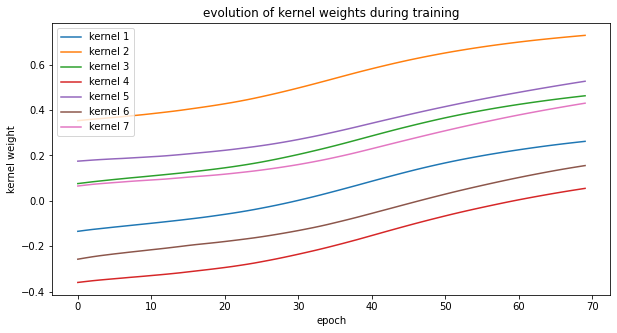

In [ ]:
def getOneKernelWeights(kernel_weights, k):
  return [w.squeeze(0).squeeze(0)[k] for w in kernel_weights]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(getOneKernelWeights(kernel_weights,0), label='kernel 1')  
ax.plot(getOneKernelWeights(kernel_weights,1), label='kernel 2')  
ax.plot(getOneKernelWeights(kernel_weights,2), label='kernel 3')  
ax.plot(getOneKernelWeights(kernel_weights,3), label='kernel 4')
ax.plot(getOneKernelWeights(kernel_weights,4), label='kernel 5')
ax.plot(getOneKernelWeights(kernel_weights,5), label='kernel 6')
ax.plot(getOneKernelWeights(kernel_weights,6), label='kernel 7')
ax.set_xlabel('epoch')  
ax.set_ylabel('kernel weight')  
ax.set_title("evolution of kernel weights during training")
ax.legend();  

### Test 

In [ ]:
# test on smooth data
test(test_set_smooth, model_smooth_conv, criterion, device, conv=True)

Test loss : 0.00030676459456667487	 accuracy : 0.9835390946502057


In [ ]:
# test on noisy data
test(test_set_noise, model_noise_conv, criterion, device, conv=True)

Test loss : 0.001022867643784103	 accuracy : 0.9423868312757202


In [ ]:
#defining the network
class Network(nn.Module):
  def __init__(self,input_shape):
    super(Network,self).__init__()
    self.fc1 = nn.Linear(input_shape,16)
    self.fc2 = nn.Linear(16,1)
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))
    return x

Training 0	loss : 0.011248174859800944	 accuracy : 0.5606060606060606


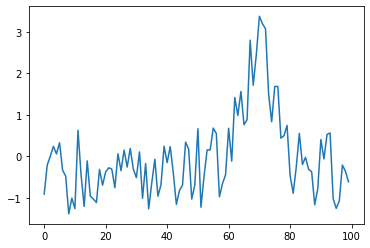

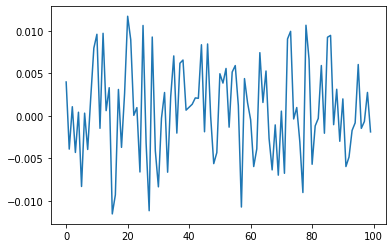

Validation 0	loss : 0.011173900753382301	 accuracy : 0.6008230452674898
Training 10	loss : 0.010090460954618848	 accuracy : 0.7961432506887053


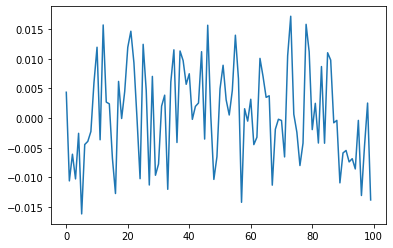

Validation 10	loss : 0.009847265212133588	 accuracy : 0.8600823045267489
Training 20	loss : 0.008574730724342599	 accuracy : 0.8870523415977961


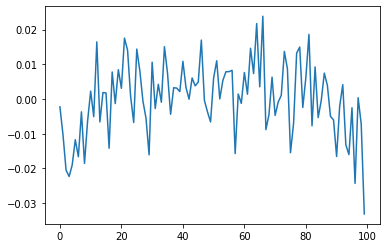

Validation 20	loss : 0.008211795317292703	 accuracy : 0.8806584362139918
Training 30	loss : 0.006863166190704367	 accuracy : 0.9132231404958677


Validation 30	loss : 0.0064873309047133836	 accuracy : 0.9135802469135802
Training 40	loss : 0.005364904842100853	 accuracy : 0.9366391184573003


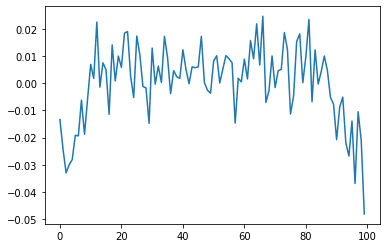

Validation 40	loss : 0.005038086524225557	 accuracy : 0.9176954732510288
Training 50	loss : 0.004224656780889211	 accuracy : 0.9476584022038568


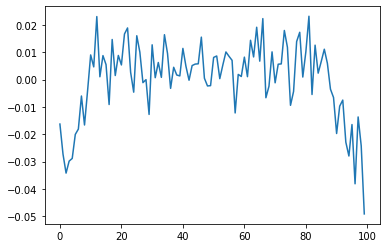

Validation 50	loss : 0.003919511236281061	 accuracy : 0.9300411522633745
Training 60	loss : 0.003383194181052121	 accuracy : 0.9559228650137741


Validation 60	loss : 0.0030903670890831654	 accuracy : 0.9300411522633745


In [ ]:
# defining the model
model = Network(100)

# smooth training
model_smooth_conv, criterion, kernel_weights, guided_gc = training(train_dl_noise, 
                                   valid_dl_smooth, model, device, 70, len(x_train_smooth), 
                                   len(x_valid_smooth), conv=False)